# County bias score
## Goal

We previously attempted to define a statewide bias score to study the influence of officer's characteristics. <br/>
It is possible that differences in the the racial repartition of local population influence this score. In order to get rid of this effect, we tried to normalise the scores by county.

However, we noticed that officers often operate on multiple counties. Hence, it was not possible to just assign an officer to a county to adjust the scores. This is why the score will now be adjusted according to the county where *each stop* occures. 

In summary, each officer will have a "county score", and his bias score will be the mean of these scores, weighted by the proportion of stops he made in each counties.

The county score is the relative variation from the mean in the county.

For the county $c$ and minority $m$, we denote $x_{c, m} = \frac{\text{Number of stops of}~m~\text{in}~c}{\text{Total number of stops over the period in}~c}$

For officer $o$, we denote $p_{c, m, o} = \frac{\text{Number of stops of}~m~\text{in}~c~\text{by}~o}{\text{Total number of stops over the period in}~c~\text{by}~o}$


Finally, $N_o$ is the total number of stops by officer $o$, and $N_{o, c}$ is the number of stops by $o$ in county $c$.

We can now define an adjusted bias score for officer $o$ towards minority $m$ :

$$\boxed{\text{Score}_{o, m} = \frac{1}{N_o}\sum_c\left( N_{o,c} \cdot \frac{p_{c, m, o} - x_{c, m}}{x_{c, m}} \right)}$$

*N.B.* : minority denotes here only an ethnie, no matter the percentage of the population it represents.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
folder = '../data/'
state = folder + 'fl_statewide.csv.zip'
state_reduced = folder + 'fl_statewide_reduced.csv.zip'
state_cleared = folder + 'fl_statewide_cleared.csv.zip'

keep_columns = ['date', 'time', 'county_name', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']
mandatory_columns = ['date', 'time', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'search_conducted']
minorities = ['white', 'hispanic', 'black']
boolean_columns = ['arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']

Data recuperation.

In [3]:
# load all dataset
df = pd.read_csv(state_cleared)
print(len(df))

2808197


Drop the useless columns and correct types.

In [4]:
df.drop(columns=df.columns.difference(keep_columns), inplace=True) # drop unused columns
df.dropna(subset=mandatory_columns, how='any', inplace=True) # drop nan values in mandatory columns
df['date'] = pd.to_datetime(df['date']) # to datetime
df['year'] = df['date'].dt.to_period('y')

df = df[df['officer_race'].isin(minorities)]
print(len(df))

2808197


Creation of a hash by officer and year:

In [5]:
def create_year_hash(df):
    df['officer_hash_year'] = df['officer_id_hash'] + '-' + df['year'].astype(str)

In [6]:
create_year_hash(df)

Let's remove officers with too few stops, with the same limit as before.

In [20]:
stops_required = 300

print("{:.0f}% of officers have enough stops.".format((df.groupby('officer_hash_year')['date'].count() > stops_required).mean()*100))

56% of officers have enough stops.


In [21]:
officers_to_keep = df.groupby('officer_hash_year')['year'].count().loc[df.groupby('officer_hash_year')['year'].count() > stops_required].index

df = df[df.officer_hash_year.isin(officers_to_keep)]

print(len(df))

2456046


### Let's create features needed for our score:

In [23]:
for minority in minorities:
    df[minority + '_stoped'] = (df['subject_race'] == minority)

#Computation the % of stops for each minority in each county
county_means = {}
for minority in minorities:
    county_means[minority] = df.groupby('county_name')[minority + '_stoped'].mean()

In [22]:
#Used to compute the score of an officer
def score_by_county(officer_df, minority, county_means, relative = True):
    county_stop_proportion_minority = officer_df.groupby('county_name')[minority + '_stoped'].mean()
    county_stop_count = officer_df.groupby('county_name')[minority + '_stoped'].count()
    county_stop_prop = county_stop_count/county_stop_count.sum()
    if (relative is True):
        return (((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])/county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()
    else:
        return ((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()

### Let's compute the score for each officer

In [24]:
scores = {}
for minority in tqdm(minorities):
    scores[minority] = df.groupby('officer_hash_year').apply(score_by_county, minority, county_means)

100%|██████████| 3/3 [00:34<00:00, 11.41s/it]


Let's link these scores to the officers.

In [26]:
officer_numerics = ['officer_age', 'officer_years_of_service']
officer_cat = ['officer_race', 'officer_sex']

# Create a dataframe with the characteristics of officers.
officer_df = df.groupby('officer_hash_year')[officer_numerics].mean()

officer_df[officer_cat] = (df[['officer_hash_year'] + officer_cat].drop_duplicates()).set_index('officer_hash_year')

# Add the bias score
for minority in minorities:
    officer_df[minority + '_bias'] = scores[minority]

## Regression performed to study the link between officer characteristics and scores.

In [27]:
for minority in minorities:
    print()
    print(f'--------------{minority.upper()}--------------')
    res = smf.ols(formula=f'{minority}_bias ~ C(officer_race) + C(officer_sex) + officer_age + officer_years_of_service', data=officer_df).fit()
    print(res.summary())
    print()
    print()


--------------WHITE--------------
                            OLS Regression Results                            
Dep. Variable:             white_bias   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.55
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           4.31e-11
Time:                        16:41:07   Log-Likelihood:                 1244.8
No. Observations:                3612   AIC:                            -2478.
Df Residuals:                    3606   BIC:                            -2440.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### There does not seem to be a link between the parameters considered and the score defined. Let's look directly at the scores according to the parameters.

In [95]:
biases = ['white_bias', 'hispanic_bias', 'black_bias']

minorities = ['white', 'hispanic', 'black']
sexes = ['male', 'female']

choice_params = {'minority':minorities, 'sex':sexes, 'age': ages}
choice_category = {'minority':'officer_race', 'sex': 'officer_sex', 'age': 'officer_generation'}

ages = ['young', 'middle', 'old']

In [97]:
def age_map(x):
    if (x < 32):
        return "young"
    elif(x > 50):
        return "old"
    else:
        return "middle"

generation = officer_df['officer_age'].apply(age_map)

officer_df['officer_generation'] = generation

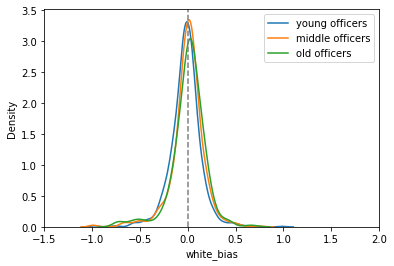

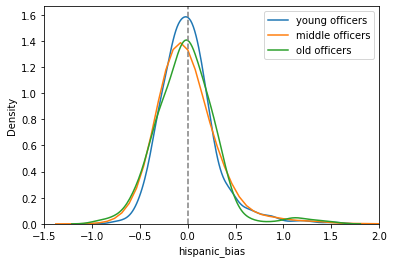

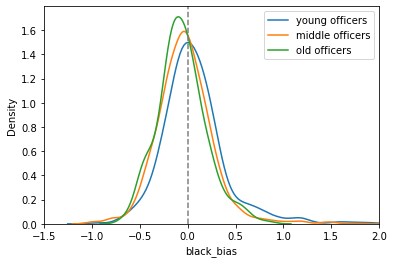

In [98]:
choice = 'age' #Possibilities : 'age', 'sex', 'minority'

for bias in biases:
    axs =  plt.axes()
    for m in choice_params[choice]:
        sns.kdeplot(officer_df[officer_df[choice_category[choice]] == m][bias], label = m + " officers", ax = axs)
    axs.axvline(x=0, ymin=0, ymax=100, linestyle='dashed', color = 'grey')
    axs.set_xlim([-1.5,2])
    plt.legend()
    plt.show()